# (84100) Farnocchia orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)
import matplotlib.pyplot as plt

In [3]:
body_id = '84100'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = 0.0
de_kernel = 441
de_kernel_path = grss.utils.default_kernel_path(de_kernel)

In [4]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_hires = False
debias_lowres = True
deweight = True
eliminate = False
max_obs_per_night = 4
verbose = True
obs_array_optical, observer_codes_optical = fit.get_mpc_optical_obs_array(body_id, de_kernel_path, optical_obs_file, t_min_tdb, t_max_tdb, debias_hires, debias_lowres, deweight, eliminate, max_obs_per_night, verbose)
obs_array_radar, observer_codes_radar = fit.get_radar_obs_array(body_id, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    obs_array_gaia, observer_codes_gaia = fit.get_gaia_optical_obs_array(body_id, de_kernel_path, t_min_tdb=None, t_max_tdb=None, verbose=True)
    obs_array_optical = np.vstack((obs_array_optical, obs_array_gaia))
    observer_codes_optical = observer_codes_optical + observer_codes_gaia

Skipped 0 observations 
	 0 of which were non-geocentric occultations, 
	 0 were either roving or radar observations (radar is handled separately), 
	 0 of which were outside the specified time range.
No debiasing needed for 505 observations. Debiased 438 observations. No biasing information for 0 observations.
Applied default weight of 1 arcsec to 38 CCD observations
Deweighted 208 observations as part of deweighting scheme.
Found 111 observations from gaiadr3
	 Added 17 of those observations.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, init_cov, obs_array_optical, observer_codes_optical, obs_array_radar, observer_codes_radar, n_iter_max=n_iter_max, de_kernel=de_kernel, de_kernel_path=de_kernel_path, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.430			 0.550			 559.048			 0.292
2			 0.430			 0.549			 559.468			 0.292
3			 0.430			 0.549			 559.468			 0.292
Converged without rejecting outliers. Starting outlier rejection now...
4			 0.405			 0.516			 490.463			 0.257
5			 0.405			 0.516			 490.495			 0.257
Converged after rejecting outliers. Rejected 4 out of 960 optical observations.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 5 (of 5):
RMS unweighted: 0.40459307791220195
RMS weighted: 0.5160333149074596
chi-squared: 490.49548564273925
reduced chi-squared: 0.2573428571053197
square root of reduced chi-squared: 0.5072897171294917
--------------------------------------------------------------
Solution Time: MJD 58005.00 TDB =  2017-09-09 00:00:00.000 TDB
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value 			Uncertainty			Change				Change (sigma)
e			2.02873972465e-01		8.68599899075e-09 		2.02873970684e-01		8.62276146017e-09 		-1.78135212137e-09		-0.205
q			2.17589058084e+00		2.17699673927e-08 		2.17589058532e+00		2.17046671313e-08 		+4.47696324457e-09		+0.206
tp			5.74183073230e+04		2.22097535155e-05 		5.74183073044e+04		2.18945376786e-05 		-1.85277094715e-05		-0.834
om			1.52357220932e+02		5.24227539771e-06 		1.52357222043e+02		5.23567180042e-06 		+1.11076474241e-06		+0.212
w			2.08340003

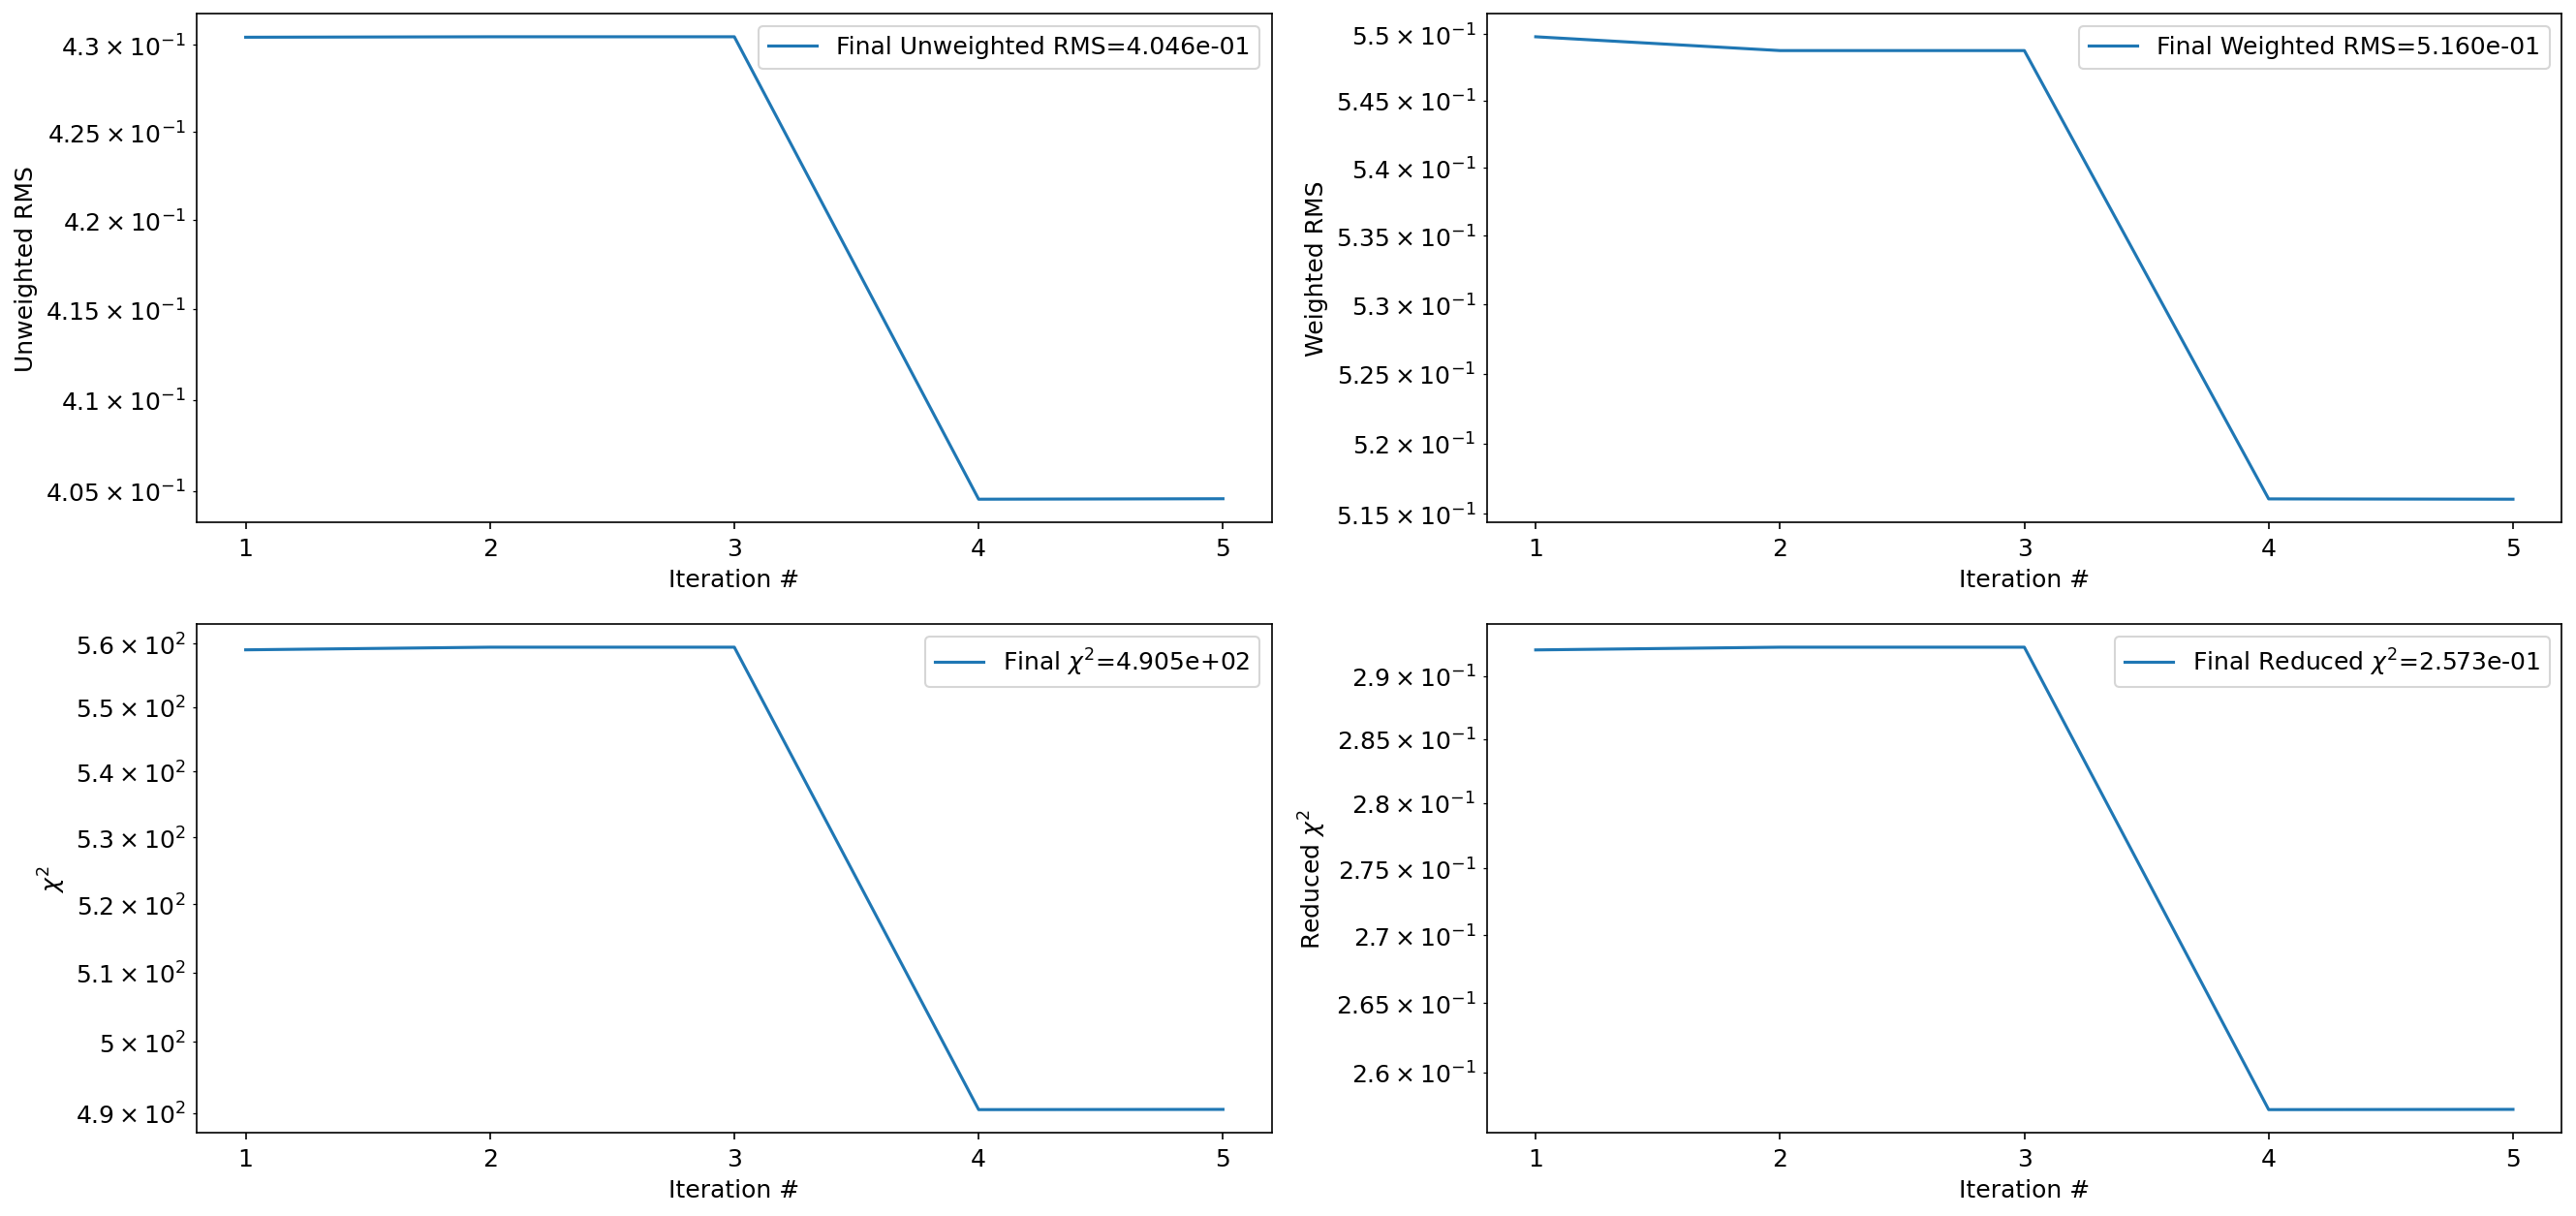

In [8]:
fit_sim.plot_summary(auto_close=True)

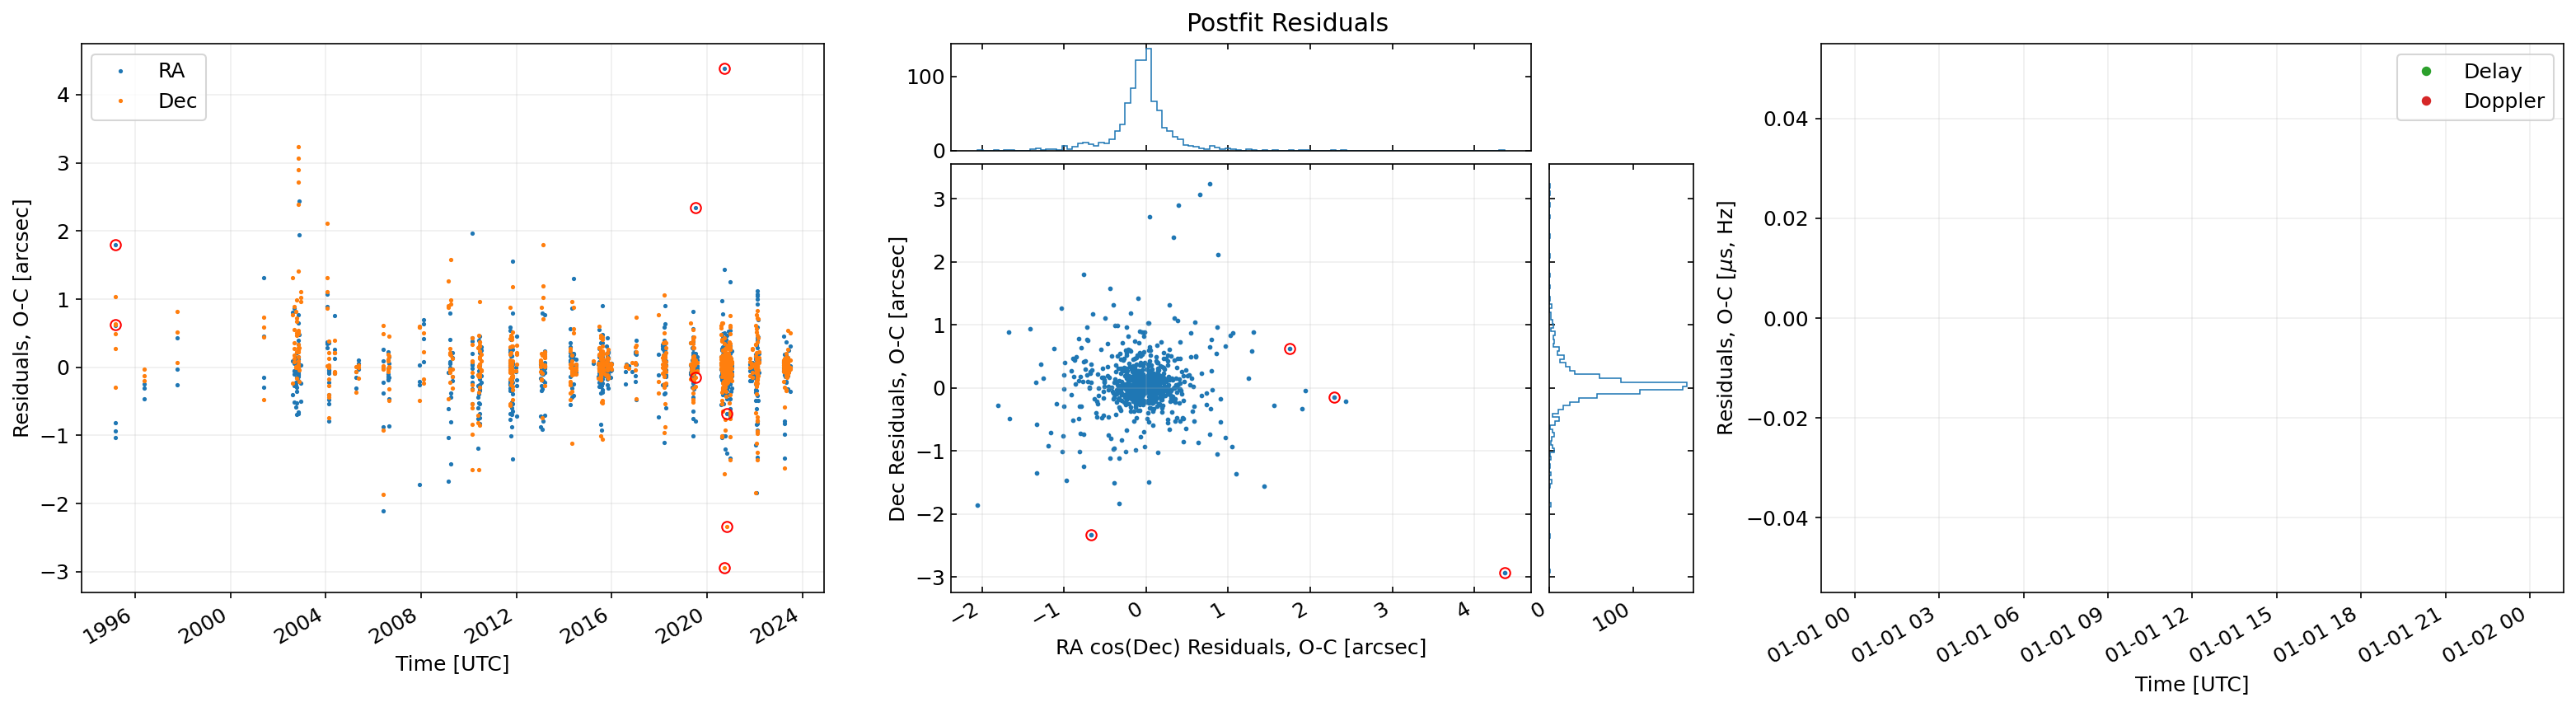

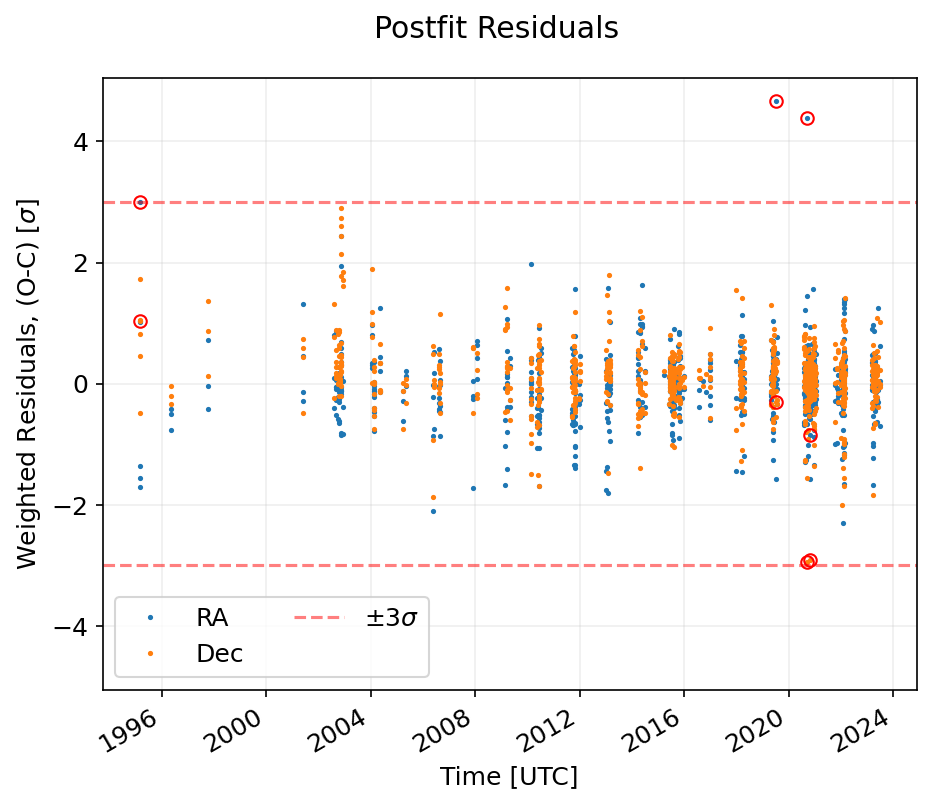

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 1.53
Mahalonobis distance between GRSS and JPL solution: 1.53
Bhattacharya distance between JPL and GRSS solution: 0.0002
Bhattacharya coefficient between JPL and GRSS solution: 0.9998


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90